###Demo use case: showing TVB flexibility. 
Set up a complete simulation and analysis  scheme imitating the exploratory workflow in studies from the  literature.
See Fig. 9 in [1]
The underlying idea is is based on [2] and [3] and probably should aim to finally
reproduce [4].

Background: 
    This demo should not be taken as an attempt to reproduce experimental results.
    It lacks from solid theoretical foundations. The background info is only
    to give a more scientifically interesting scenario and justify the choices
    of the observed nodes and such. 
    
    When thinking about stimulation paradigms in the context of a whole brain 
    experimental protocol, the first ones that jump to my mind: 
        - face/object recognition.
        - visually evoked potentials (VEP).
        - trans-cranial magnetic stimulation (TMS).
        
    
    The constraints: 
        - Make a demo as simple as possible and thus not including the sub-cortical
          structures. Many sensory inputs go first through the thalamus and then
          its projections reach the cortex. 
        - Directly stimulating the cortex with an arbitrary stimulus. Intensity 
          units are arbitrary.   
    
    Finally, the stimulus is a Pulse Train with a frequency repetition of 4Hz. 
    This low value is the frequency used for flashing stimuli.  Visual stimuli 
    stimulate both primary visual and secondary visual areas (V1, V2)
    
    Recordings from scalp: the mid-occipital electrode location (OZ) as in [2] and
    because we are stimulating the visual cortex.  

Steps: 
    1. Set up basic simulation components
    2. Build a stimulation pattern
    3. Generate simulated data with and without stimulation. 
    4. Compute MSE
    5. Plot results

Objective:
   Compare the complexity in the resting state against evoked activity, based
   on MSE computed on the EEG time-series from sensor Oz (occipital region).
   The scientific motivation is (would be) to evaluate how complexity changes as 
   a function of stimulation.

    
Sim Info: 
    Node indices corresponding to left  temporal and visual cortices (30:36).
    - assuming the Connectivity matrix is the default with 74 nodes.

    EEG electrode indice corresponding to O1, O2 and Oz (8, 9, 60).
    The EEG sensors represent 62 scalp electrodes distributed according to the 
    10–20 system.

[1] Sanz Leon P.; Woodman; M.; Knock; S.; (...); Jirsa, V. The Virtual Brain: a
    simulator of primate brain dynamics. Frontiers in Neuroinformatics.

[2] McIntosh, A.; Kovacevic, N.; Lippe, S.; Garrett, D.; Grady, C. & Jirsa, V. 
    The Development of a Noisy Brain Archives Italiennes de Biologie, 2010, 148, -
[3] Schneider, G. E. Two visual systems. Science, 1969, 163, 895-902

Recommended:

[4] David, O. & Friston, K. J. A neural mass model for MEG/EEG: coupling and 
neuronal dynamics. Neuroimage.


Total runtime ~ 10 min on Intel Xeon(R) CPU W3520 @ 2.67GHz 

SSVEP: Steady State Visually Evoked Potentials.  There is a number of points to be 
determined. Selection of electrodes and stimulating frequencies, feature extraction 
(MSE?), spectral methods. Lead position is important, however for VEPs, normally 
electrode at the occipital region are selected.

TCc --> central temporal cortex								
TCi --> inferior temporal cortex	

In [11]:
%pylab inline

In [12]:
from tvb.simulator.lab import *
import matplotlib.gridspec as gridspec
from tvb.datatypes.projections import ProjectionSurfaceEEG
from tvb.datatypes.sensors import SensorsEEG
from tvb.datatypes.region_mapping import RegionMapping

# lV1, lV2,
nodes = [35, 36]

# O1, O2, Oz
eeg_nodes = [8, 9, 60]

# discard transients for analysis
start = 2048 * 2 - 128  # at 1 second
# for pretty pictures
stop = 2048 * 5 - 64  # 2.5 second

Set up a simulator  instance 

In [13]:
def configure_simulation(stimulate):
    """
    Set up a Simulator object (a brain network model and all its individual 
    components + output modalities)
    """
    # eeg projection matrix from regions to sensors
    LOG.info("Reading sensors info")

    pr = ProjectionSurfaceEEG(load_default=True)
    sensors = SensorsEEG.from_file(source_file="eeg_brainstorm_65.txt")
    rm = RegionMapping(load_default=True)

    #Initialise a Model, Connectivity, Coupling, set speed.
    oscilator = models.Generic2dOscillator(a=-0.5, b=-10., c=0.0, d=0.02)

    white_matter = connectivity.Connectivity(load_default=True)
    white_matter.speed = numpy.array([4.0])
    white_matter_coupling = coupling.Linear(a=0.042)

    #Initialise an Integrator
    hiss = noise.Additive(nsig=numpy.array([0.00]))  # nsigm 0.015
    heunint = integrators.HeunStochastic(dt=2 ** -6, noise=hiss)

    # Recording techniques
    what_to_watch = (monitors.TemporalAverage(period=1e3 / 4096.),
                     monitors.EEG(projection=pr, sensors=sensors, region_mapping=rm, period=1e3 / 4096.))
    # Stimulation paradigm
    if stimulate:
        stimulus = build_stimulus(white_matter)
    else:
        stimulus = None

    #Initialise a Simulator -- Model, Connectivity, Integrator, and Monitors.
    sim = simulator.Simulator(model=oscilator, connectivity=white_matter, coupling=white_matter_coupling,
                              integrator=heunint, monitors=what_to_watch, stimulus=stimulus)
    sim.configure()
    return sim
    

In [14]:
def run_simulation(sim):
    LOG.info("Starting simulation...")
    #Perform the simulation
    tavg_data = []
    tavg_time = []
    eeg_data = []
    eeg_time = []

    for tavg, eeg in sim(simulation_length=2 ** 12):
    # approx 4 sec
        if not tavg is None:
            tavg_time.append(tavg[0])
            tavg_data.append(tavg[1])

        if not eeg is None:
            eeg_time.append(eeg[0])
            eeg_data.append(eeg[1])

    LOG.info("Finished simulation.")
    return tavg_data, tavg_time, eeg_data, eeg_time, sim.stimulus

In [15]:
def build_stimulus(white_matter):
    """
    Build a rectangular pulse train using an Equation datatype
    """

    # access the region indices
    white_matter.configure()

    # specify weights for regions receiving stimulation  
    weighting = numpy.zeros((white_matter.number_of_regions, 1))
    weighting[nodes] = numpy.array([3.5, 0.0])[:, numpy.newaxis]

    eqn_t = equations.PulseTrain()
    eqn_t.parameters["onset"] = 1000.0  # ms
    eqn_t.parameters["tau"] = 5.0    # ms
    eqn_t.parameters["T"] = 750.  # ms --> 0.0015kHz repetition frequency

    stimulus = patterns.StimuliRegion(temporal=eqn_t, connectivity=white_matter, weight=weighting)
    return stimulus

In [16]:
def compute_mse(xs_data, ys_data):
    """
    Not trying to be smart. Only computing MSE for two different time series.
    e.g
    x: resting state eeg
    y: evoked activity eeg
    """
    from tvb.analyzers.info import sampen

    x = numpy.array(xs_data)
    y = numpy.array(ys_data)

    sampen_x = sampen(x[2048:, 0, eeg_nodes[2], 0], r=.15, taus=numpy.r_[4:13], qse=False, m=2)
    sampen_y = sampen(y[2048:, 0, eeg_nodes[2], 0], r=.15, taus=numpy.r_[4:13], qse=False, m=2)

    return sampen_x, sampen_y

In [17]:
def save_data(tavg_data, eeg_data, tavg_time, eeg_time, stimulus=None):
    """
    Save simulated data
    """

    TAVG = numpy.array(tavg_data)
    EEG = numpy.array(eeg_data)

    if stimulus is None:
        FILE_NAME = "rs_tavg_data_region_4s_2048Hz.npy"
        LOG.info("Saving array to %s..." % FILE_NAME)
        numpy.save(FILE_NAME, TAVG)

        FILE_NAME = "rs_eeg_data_region_4s_2048Hz.npy"
        LOG.info("Saving array to %s..." % FILE_NAME)
        numpy.save(FILE_NAME, EEG)

    else:
        FILE_NAME = "stim_eeg_data_region_4s_2048Hz.npy"
        LOG.info("Saving array to %s..." % FILE_NAME)
        numpy.save(FILE_NAME, EEG)

        FILE_NAME = "stim_tavg_data_region_4s_2048Hz.npy"
        LOG.info("Saving array to %s..." % FILE_NAME)
        numpy.save(FILE_NAME, TAVG)

        FILE_NAME = "stim_pattern_data_region_4s.npy"
        LOG.info("Saving array to %s..." % FILE_NAME)
        numpy.save(FILE_NAME, stimulus.temporal.pattern)

    FILE_NAME = "time_tavg_data_region_4s_2048Hz.npy"
    LOG.info("Saving array to %s..." % FILE_NAME)
    numpy.save(FILE_NAME, numpy.array(tavg_time))

    FILE_NAME = "time_eeg_data_region_4s_2048Hz.npy"
    LOG.info("Saving array to %s..." % FILE_NAME)
    numpy.save(FILE_NAME, numpy.array(eeg_time))

    # I'm assuming both tavg and eeg time vectors have the tpts sampled at 
    # the same frequency.

In [24]:
def plot_figure(se_x, se_y, eeg_data, tavg_data, rseeg, rstavg, pattern, nodes, eeg_nodes, time):
    """
    Generate figure as shown in [1].
    se_x: mse estimates for resting state like
    se_y: mse estimates for evoked activity
    eeg_data: evoked eeg
    tavg_data: evoked raw data
    rseeg: resting state eeg
    rstavg: resting state raw
    nodes:regions of interest
    eeg_nodes: sensors of itnerest
    time: time vector
    """

    fig_width_pt = 1200.0  # Get this from LaTeX using \showthe\columnwidth
    inches_per_pt = 1.0 / 72.27               # Convert pt to inch
    golden_mean = (numpy.sqrt(5) + 1.0) / 2.0         # Aesthetic ratio
    fig_width = fig_width_pt * inches_per_pt  # width in inches
    fig_height = fig_width * golden_mean      # height in inches
    fig_size = [fig_height, fig_width]
    params = {'backend': 'ps',
              'axes.labelsize': 26,
              'text.fontsize': 20,
              'legend.fontsize': 30,
              'xtick.labelsize': 24,
              'ytick.labelsize': 24,
              'text.usetex': False,
              'figure.figsize': fig_size}
    pyplot.rcParams.update(params)
    pyplot.locator_params(axis='y', nbins=4)

    # assuming resting state time series
    tavg_data = numpy.array(tavg_data)

    # assuming evoked activity
    eeg_data = numpy.array(eeg_data)

    # subsample the stimulus
    pattern = pattern[:, ::pattern.shape[1] / eeg_data.shape[0]].T
    pattern = pattern[:-1, :]

    plot_ts = True
    if plot_ts:
        figure(1)
        # create a nice subplot layout
        gs = gridspec.GridSpec(6, 4)

        ax1 = subplot(gs[:2, :-1])
        ax1z = subplot(gs[:2, -1])

        ax0 = subplot(gs[2, :-1])
        ax0z = subplot(gs[2, -1])
        ax2 = subplot(gs[3:5, :-1])
        ax2z = subplot(gs[3:5, -1])

        # ER raw traces + stimulation pattern
        temp_v2 = tavg_data[start:stop, 0, nodes[1], 0]
        temp_v1 = tavg_data[start:stop, 0, nodes[0], 0]

        temp_v1 = (temp_v1 - temp_v1.min())
        temp_v2 = (temp_v2 - temp_v2.min())

        temp_v1 /= abs(temp_v1.max())
        temp_v2 /= abs(temp_v2.max())
        temp_v2 *= 0.25

        temp_v2 += temp_v1.max() + 0.5  # offset for pretty pictures

        ## V2-V1 stochastic 

        ax1.plot(time[start:stop], temp_v2, color='#1C79FC', lw=3, label="V2")
        ax1.plot(time[start:stop], temp_v1, 'k', lw=3, label="V1")
        ax1.patch.set_facecolor('#1C79FC')
        ax1.patch.set_alpha(0.15)
        ax1.set_xlim([time[start], time[stop - 1]])
        ax1.set_ylim([temp_v1.min() - 0.15, temp_v2.max() + 0.15])

        ##  V2-V1 stochastic  - Zoom in 
        ax1z.plot(time[start:stop // 2], tavg_data[start:stop // 2, 0, nodes[1], 0], color='#1C79FC', lw=3, label="V2")
        ax1z.plot(time[start:stop // 2], tavg_data[start:stop // 2, 0, nodes[0], 0], 'k', lw=3, label="V1")
        ax1z.patch.set_facecolor('#1C79FC')
        ax1z.patch.set_alpha(0.15)
        ax1z.axes.get_xaxis().set_visible(False)
        ax1z.set_xlabel("time (ms)")

        ax1.axes.get_xaxis().set_visible(False)
        setp(ax1.get_yticklabels(), visible=False)
        ax1.set_ylabel("raw traces")
        ax1.set_xlabel("time (ms)")
        ax1.legend()

        ## pp

        ## stimulus pattern
        ax0.plot(time[start:stop], pattern[start:stop], 'r', linewidth=3, alpha=0.4, label="stim")
        ax0.set_xlim([time[start], time[stop - 1]])
        ax0.axes.get_xaxis().set_visible(False)
        ax0.set_ylim([-0.1, 1.25])
        setp(ax0.get_yticklabels(), visible=False)
        ax0.set_ylabel("stimulus")

        ##  Stimulus pattern  - Zoom in 
        ax0z.plot(time[start:stop // 2], 3.5 * pattern[start:stop // 2], 'r', linewidth=3, alpha=0.4, label="stim")
        ax0z.axes.get_xaxis().set_visible(False)
        ax0z.set_ylim([-0.1, 3.75])

        # eeg traces
        temp_oz = eeg_data[start:stop, 0, eeg_nodes[2], 0]
        temp_o1 = eeg_data[start:stop, 0, eeg_nodes[0], 0]

        temp_oz = (temp_oz - temp_oz.min())
        temp_o1 = (temp_o1 - temp_o1.min())

        temp_oz += temp_o1.max()

        ax2.plot(time[start:stop], temp_oz, 'k', lw=2, label="OZ")
        ax2.plot(time[start:stop], temp_o1, color='0.55', lw=2, label="O1")
        ax2.patch.set_facecolor('red')
        ax2.patch.set_alpha(0.10)
        ax2.set_xlim([time[start], time[stop - 1]])
        ax2.set_ylim([temp_o1.min() - 0.15, temp_oz.max() + 0.15])
        ax2.set_xlabel("time (ms)")
        setp(ax2.get_yticklabels(), visible=False)
        ax2.set_ylabel("EEG ")
        ax2.legend()

        ## zoom in 
        ax2z.plot(time[start:stop // 2], eeg_data[start:stop // 2, 0, eeg_nodes[2], 0], 'k', lw=2, label="OZ")
        ax2z.plot(time[start:stop // 2], eeg_data[start:stop // 2, 0, eeg_nodes[0], 0], color='0.55', lw=2, label="O1")
        ax2z.patch.set_facecolor('red')
        ax2z.patch.set_alpha(0.1)
        ax2z.set_xticks([1000, 1100, 1200])
        ax2z.set_xlabel("time (ms)")
        show()
        #savefig("Fig11_sampen_sto.pdf")

    plot_sampen = True
    if plot_sampen:
        figure(2)
        rseeg_data = numpy.array(rseeg)
        gs = gridspec.GridSpec(3, 1)

        ax0 = subplot(gs[0, :])
        ax1 = subplot(gs[1, :])
        ax2 = subplot(gs[2, :])

        ax0.plot(time[start:stop], rseeg_data[start:stop, 0, eeg_nodes[2], 0], 'k', lw=2, label="OZ-RS")
        ax0.set_xlim([time[start], time[stop - 1]])
        ax0.set_ylim([-25, 55])
        ax0.axes.get_xaxis().set_visible(False)
        ax0.patch.set_facecolor('green')
        ax0.legend(loc=2)
        ax0.patch.set_alpha(0.15)

        pattern = (pattern * 8.) - 24.
        ax1.plot(time[start:stop], eeg_data[start:stop, 0, eeg_nodes[2], 0], 'k', lw=2, label="OZ-ER")
        ax1.plot(time[start:stop], pattern[start:stop], 'k', linewidth=3, alpha=0.4, label="stim")
        ax1.set_xlim([time[start], time[stop]])
        ax1.set_ylim([-25, 55])
        ax1.set_xlabel("time [ms]")
        ax1.patch.set_facecolor('blue')
        ax1.patch.set_alpha(0.15)
        ax1.legend(loc=2)

        # sample entropy
        ax2.plot(numpy.r_[4:13], se_x, 'k--', label="resting state", linewidth=3)
        ax2.plot(numpy.r_[4:13], se_y, 'k', label="evoked activity", linewidth=3)
        ax2.set_xlim([4, 12])
        ax2.set_ylabel("MSE")
        ax2.set_xlabel("temporal scale")
        ax2.legend(loc=2)
        show()
        #savefig("Fig12_mse.pdf")

In [25]:
def main():
    # First simulation --> resting state
    sim = configure_simulation(stimulate=False)
    ts, tt, es, et, _ = run_simulation(sim)

    # Second simulation -- > evoked responses
    sim_stim = configure_simulation(stimulate=True)
    sts, stt, ses, sett, stim = run_simulation(sim_stim)

    save_data(sts, ses, stt, sett, stim)

    # Analyze --> compute sample entropy
    se_x, se_y = compute_mse(es, ses)

    # Visualize
    pattern = stim.temporal.pattern
    plot_figure(se_x, se_y, ses, sts, es, ts, pattern, nodes, eeg_nodes, et)

    return LOG.info("""Done.""")

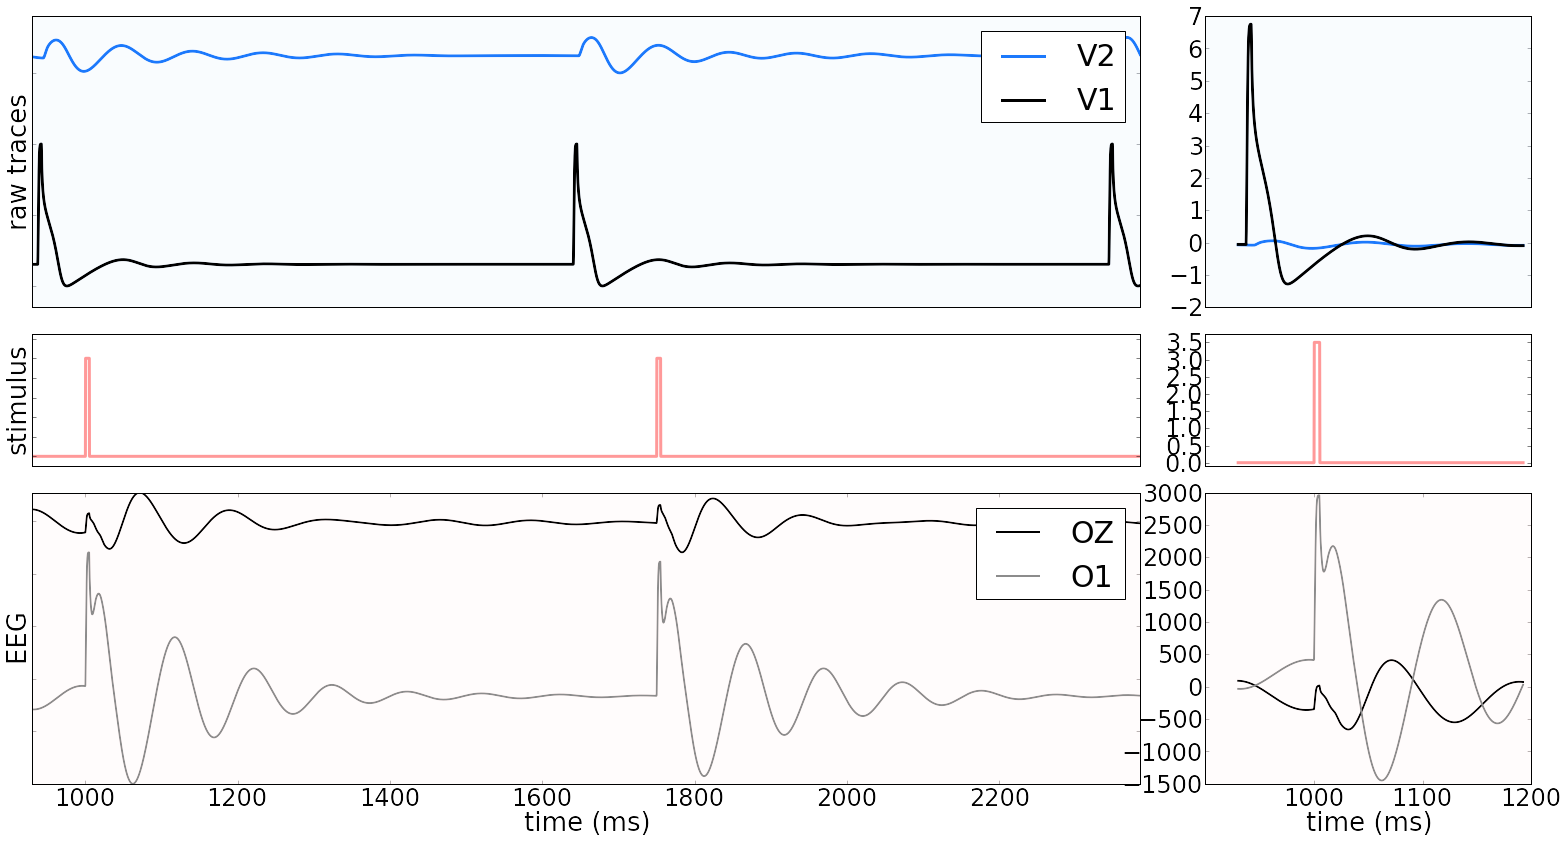

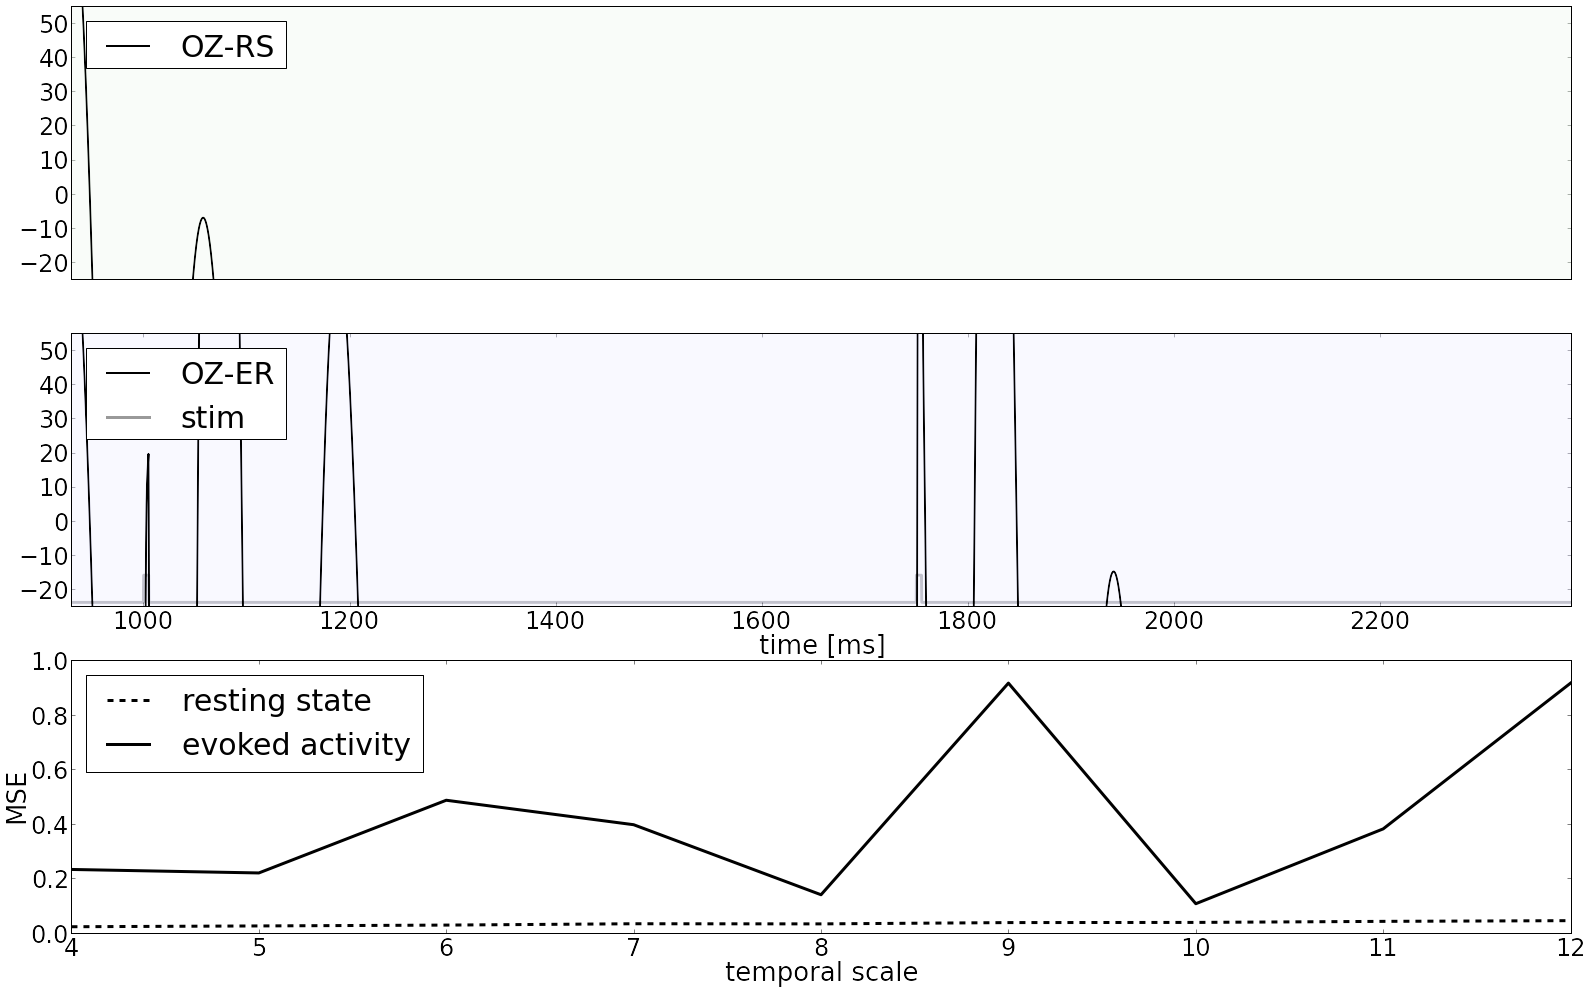

In [26]:
if __name__ == "__main__":
    main()